In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from tqdm import tqdm
%matplotlib inline

In [2]:

words = open('names.txt', 'r').read().splitlines()
words[:4]

['emma', 'olivia', 'ava', 'isabella']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


In [227]:
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to p
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context [1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed (42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [228]:
def cmp(s,dt,t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt,t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate | {str(app):5s} | maxdiff: {maxdiff}')

In [248]:
n_hidden = 300
embedding_size = 10
block_size = 3
vocab_size = 27

#embedding
g = torch.Generator().manual_seed(123)
C = torch.randn((vocab_size,embedding_size),             generator = g)
# first layer
W1 = torch.randn((block_size*embedding_size,n_hidden),   generator = g) * (5/3) / ((embedding_size * block_size)**0.5)
b1 = torch.randn(n_hidden,                               generator = g) * 0.1
#second layer
W2 = torch.randn((n_hidden,vocab_size),                  generator = g) * 0.1
b2 = torch.randn(vocab_size,                             generator = g) * 0.1
#batchnorm
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

running_bnmean = torch.ones((1,n_hidden)) * 0.1 + 1
running_bnstd = torch.zeros((1,n_hidden)) * 0.1 

parameters = [C,W1,b1,W2,b2,bngain,bnbias]


sum(p.nelement() for p in parameters)

for p in parameters:
    p.requires_grad = True

In [249]:
# calculate single batch 
batch_size = 32
n = batch_size

ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
Xb,Yb = Xtr[ix], Ytr[ix]

In [253]:
# forward pass 

#embed
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
#linear layer 1
hprebn = embcat @ W1 + b1
#batchnorm
bnmeani = 1/n *  hprebn.sum(0, keepdim = True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1) * (bndiff2).sum(0, keepdim = True)
bnvar_inv = (bnvar + 1e-5) ** (-0.5)
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
#non-linearity
h = torch.tanh(hpreact)
#linear layer 2
logits = h @ W2 + b2

# cross entropy loss
logit_maxes = logits.max(1, keepdim = True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim = True)
counts_sum_inv = counts_sum ** -1
probs = counts*counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

#backward
for p in parameters:
    p.grad = None

for t in[logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes, logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
    t.retain_grad()
    
loss.backward()
loss

tensor(3.9835, grad_fn=<NegBackward0>)

In [254]:
bndiff.shape, hprebn.shape, bnmeani.shape

(torch.Size([32, 300]), torch.Size([32, 300]), torch.Size([1, 300]))

In [ ]:
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
#linear layer 1
hprebn = embcat @ W1 + b1

In [275]:
dhprebn.shape, embcat.shape, W1.shape, b1.shape,emb.shape,C.shape

(torch.Size([32, 300]),
 torch.Size([32, 30]),
 torch.Size([30, 300]),
 torch.Size([300]),
 torch.Size([32, 3, 10]),
 torch.Size([27, 10]))

W1              | exact: True  | approximate | True  | maxdiff: 0.0
embcat          | exact: True  | approximate | True  | maxdiff: 0.0
b1              | exact: True  | approximate | True  | maxdiff: 0.0
emb             | exact: True  | approximate | True  | maxdiff: 0.0
C               | exact: True  | approximate | True  | maxdiff: 0.0


In [262]:
dW1.shape,W1.shape

(torch.Size([300, 30]), torch.Size([30, 300]))

In [278]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n),Yb] = -1.0/n
cmp('logprobs', dlogprobs,logprobs)

dprobs = probs**-1 * dlogprobs
cmp('probs', dprobs,probs)


dcounts_sum_inv =  (counts * dprobs).sum(1, keepdim = True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

dcounts_sum = dcounts_sum_inv * -1 * counts_sum**-2
cmp('dcounts_sum', dcounts_sum, counts_sum)

dcounts = counts_sum_inv * dprobs
dcounts += torch.ones_like(counts) * dcounts_sum
cmp('counts', dcounts,counts)

dnorm_logits = norm_logits.exp() * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)

dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
cmp('logit_maxes', dlogit_maxes,logit_maxes)

dlogits = dnorm_logits.clone()
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
cmp('logits', dlogits,logits)

dh = dlogits @ W2.T
cmp('h', dh,h)

dW2 = h.T @ dlogits
cmp('w2', dW2,W2)

db2 = dlogits.clone().sum(0, keepdim = True)
cmp('b2', db2,b2)

dhpreact = (1 - torch.tanh(hpreact)**2) * dh
cmp('hpreact', dhpreact,hpreact)

dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
cmp('bngain', dbngain,bngain)

dbnraw = dhpreact * torch.ones_like(bnraw)*bngain
cmp('bnraw', dbnraw,bnraw)

dbnbias = dhpreact.sum(0, keepdim = True)
cmp('bnbias', dbnbias, bnbias)

dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim = True)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

dbnvar = dbnvar_inv * (bnvar + 1e-5)**(-3/2) * (-0.5)
cmp('bnvar', dbnvar, bnvar)

dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar
cmp('bndiff2', dbndiff2,bndiff2)

dbndiff = 2*bndiff * dbndiff2 + dbnraw * torch.ones_like(bndiff) * bnvar_inv
cmp('bndiff', dbndiff, bndiff)

dhprebn =  dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
cmp('bnmeani', dbnmeani,bnmeani)

dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
cmp('hprebn', dhprebn, hprebn)

dW1 = embcat.T @ dhprebn
cmp('W1', dW1,W1)

dembcat = dhprebn @ W1.T
cmp('embcat', dembcat, embcat)

db1 = dhprebn.sum(0)
cmp('b1', db1,b1)

demb = dembcat.view((32,3,-1))
cmp('emb',demb,emb)

dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]

cmp('C',dC,C)

logprobs        | exact: True  | approximate | True  | maxdiff: 0.0
probs           | exact: True  | approximate | True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate | True  | maxdiff: 0.0
dcounts_sum     | exact: True  | approximate | True  | maxdiff: 0.0
counts          | exact: True  | approximate | True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate | True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate | True  | maxdiff: 0.0
logits          | exact: True  | approximate | True  | maxdiff: 0.0
h               | exact: True  | approximate | True  | maxdiff: 0.0
w2              | exact: True  | approximate | True  | maxdiff: 0.0
b2              | exact: True  | approximate | True  | maxdiff: 0.0
hpreact         | exact: True  | approximate | True  | maxdiff: 0.0
bngain          | exact: True  | approximate | True  | maxdiff: 0.0
bnraw           | exact: True  | approximate | True  | maxdiff: 0.0
bnbias          | exact: True  | approximate | T

In [279]:
loss_last = F.cross_entropy(logits, Yb)
loss_last

tensor(3.9835, grad_fn=<NllLossBackward0>)

In [291]:
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n
cmp('logits',dlogits,logits)

logits          | exact: False | approximate | True  | maxdiff: 7.916241884231567e-09


In [59]:
batch_size = 32

for _ in tqdm(range(10000)):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator = g)

    Xb,Yb = Xtr[ix], Ytr[ix]
    #forward
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1 #pre activation 
    bnmeani =  hpreact.mean(0, keepdim = True)
    bnstdi = hpreact.std(0, keepdim = True)
    hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Yb)
    
    
    #backward
    for p in parameters:
        p.grad = None
    loss.backward()

    with torch.no_grad():
        running_bnmean = running_bnmean * 0.999 + bnmeani * 0.001
        running_bnstd = running_bnstd * 0.999 + bnstdi * 0.001



    #update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(_)
    lossi.append(loss.log10().item())
print(loss.item())

100%|██████████| 10000/10000 [00:44<00:00, 222.59it/s]

3.0187876224517822


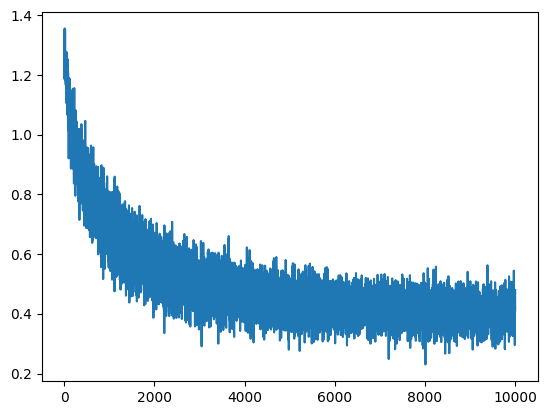

In [60]:
plt.plot(stepi,lossi)

In [61]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y  = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact. std(0, keepdim=True) + bnbias
    hpreact = bngain * ((hpreact - running_bnmean) / running_bnstd) + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy (logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.4744350910186768
val 2.4798104763031006


In [ ]:
xw